In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import cv2
import scipy.io
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

%matplotlib inline

In [2]:
def get_metadata_from_mat_file(matfile: str, key: str) -> list:
    metadata = []
    mat = scipy.io.loadmat(matfile)
    
    _id = mat[key][0][0][2][0]
    gender = mat[key][0][0][3][0]
    dob = np.int32(mat[key][0][0][0][0] / 365)
    photo = mat[key][0][0][1][0]
    age = photo - dob
    
    for i in range(len(_id)):
        record = {}
        record["id"] = str(_id[i][0][3:])
        record["year_of_birth"] = dob[i]
        record["year_of_photo"] = photo[i]
        record["age"] = age[i]
        record["gender"] = np.uint8(gender[i])
        record["valid"] = (record["age"] <= 100) & (record["age"] > 0)
        metadata.append(record)    
    return metadata

def get_metadata(matfile_imdb: str, matfile_wiki: str) -> list:
    if matfile_imdb is None and matfile_wiki is None:
        keys = []
        files = []
    elif matfile_imdb is None:
        keys = ["wiki"]
        files = [matfile_wiki]
    elif matfile_wiki is None:
        keys = ["imdb"]
        files = [matfile_imdb]
    else:
        keys = ["imdb", "wiki"]
        files = [matfile_imdb, matfile_wiki]
    
    metadata = [get_metadata_from_mat_file(files[i], keys[i]) for i in range(len(keys))]
    
    return pd.DataFrame([item for sublist in metadata for item in sublist])

In [3]:
df_metadata = get_metadata(matfile_imdb="./images/imdb_crop/imdb.mat", matfile_wiki=None)

In [4]:
def is_numeric(s: str) -> bool:
    m = re.match(pattern="\d+", string=s)
    if m is not None:
        return True
    else:
        return False

In [14]:
def get_input_tensor(dir1: str, metadata: pd.DataFrame, img_size=64, max_dirs=25) -> tuple:
    images_tensors = []
    gender_labels = []
    age_labels = []
    ids = []
    for subdir in os.listdir(dir1):
        if is_numeric(subdir) and int(subdir) <= max_dirs:
            print(f"Analyzing subdir {subdir} / {max_dirs} ...")
            images_paths = os.listdir(dir1 + subdir)
            for img_path in images_paths:
                data_img = metadata.loc[metadata["id"]==img_path,:]
                if img_path.lower().endswith(".jpg") and data_img["valid"].values[0]:
                    img = cv2.imread(dir1 + subdir + "/" + img_path, 0)  # monochrome
                    if (img.shape[0] >= img_size) and (img.shape[1] >= img_size):
                        img_array = cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
                        img_array = img_array / 255 # normalization
                        img_tensor = np.expand_dims(img_array, axis=0)
                        images_tensors.append(img_tensor)
                        gender_labels.append(data_img["gender"].values[0])
                        age_labels.append(data_img["age"].values[0])
                        ids.append(data_img["id"].values[0])
    print("Building input tensor and target arrays ... ")
    return np.concatenate(images_tensors), np.array(gender_labels), np.array(age_labels), np.array(ids)

In [63]:
input_tensor, gender_labels, age_labels, ids = get_input_tensor("images/imdb_crop/", df_metadata, img_size=128)

Analyzing subdir 00 / 25 ...
Analyzing subdir 01 / 25 ...
Analyzing subdir 02 / 25 ...
Analyzing subdir 03 / 25 ...
Analyzing subdir 04 / 25 ...
Analyzing subdir 05 / 25 ...
Analyzing subdir 06 / 25 ...
Analyzing subdir 07 / 25 ...
Analyzing subdir 08 / 25 ...
Analyzing subdir 09 / 25 ...
Analyzing subdir 10 / 25 ...
Analyzing subdir 11 / 25 ...
Analyzing subdir 12 / 25 ...
Analyzing subdir 13 / 25 ...
Analyzing subdir 14 / 25 ...
Analyzing subdir 15 / 25 ...
Analyzing subdir 16 / 25 ...
Analyzing subdir 17 / 25 ...
Analyzing subdir 18 / 25 ...
Analyzing subdir 19 / 25 ...
Analyzing subdir 20 / 25 ...
Analyzing subdir 21 / 25 ...
Analyzing subdir 22 / 25 ...
Analyzing subdir 23 / 25 ...
Analyzing subdir 24 / 25 ...
Analyzing subdir 25 / 25 ...
Building input tensor and target arrays ... 


In [64]:
input_tensor.shape

(95310, 128, 128)

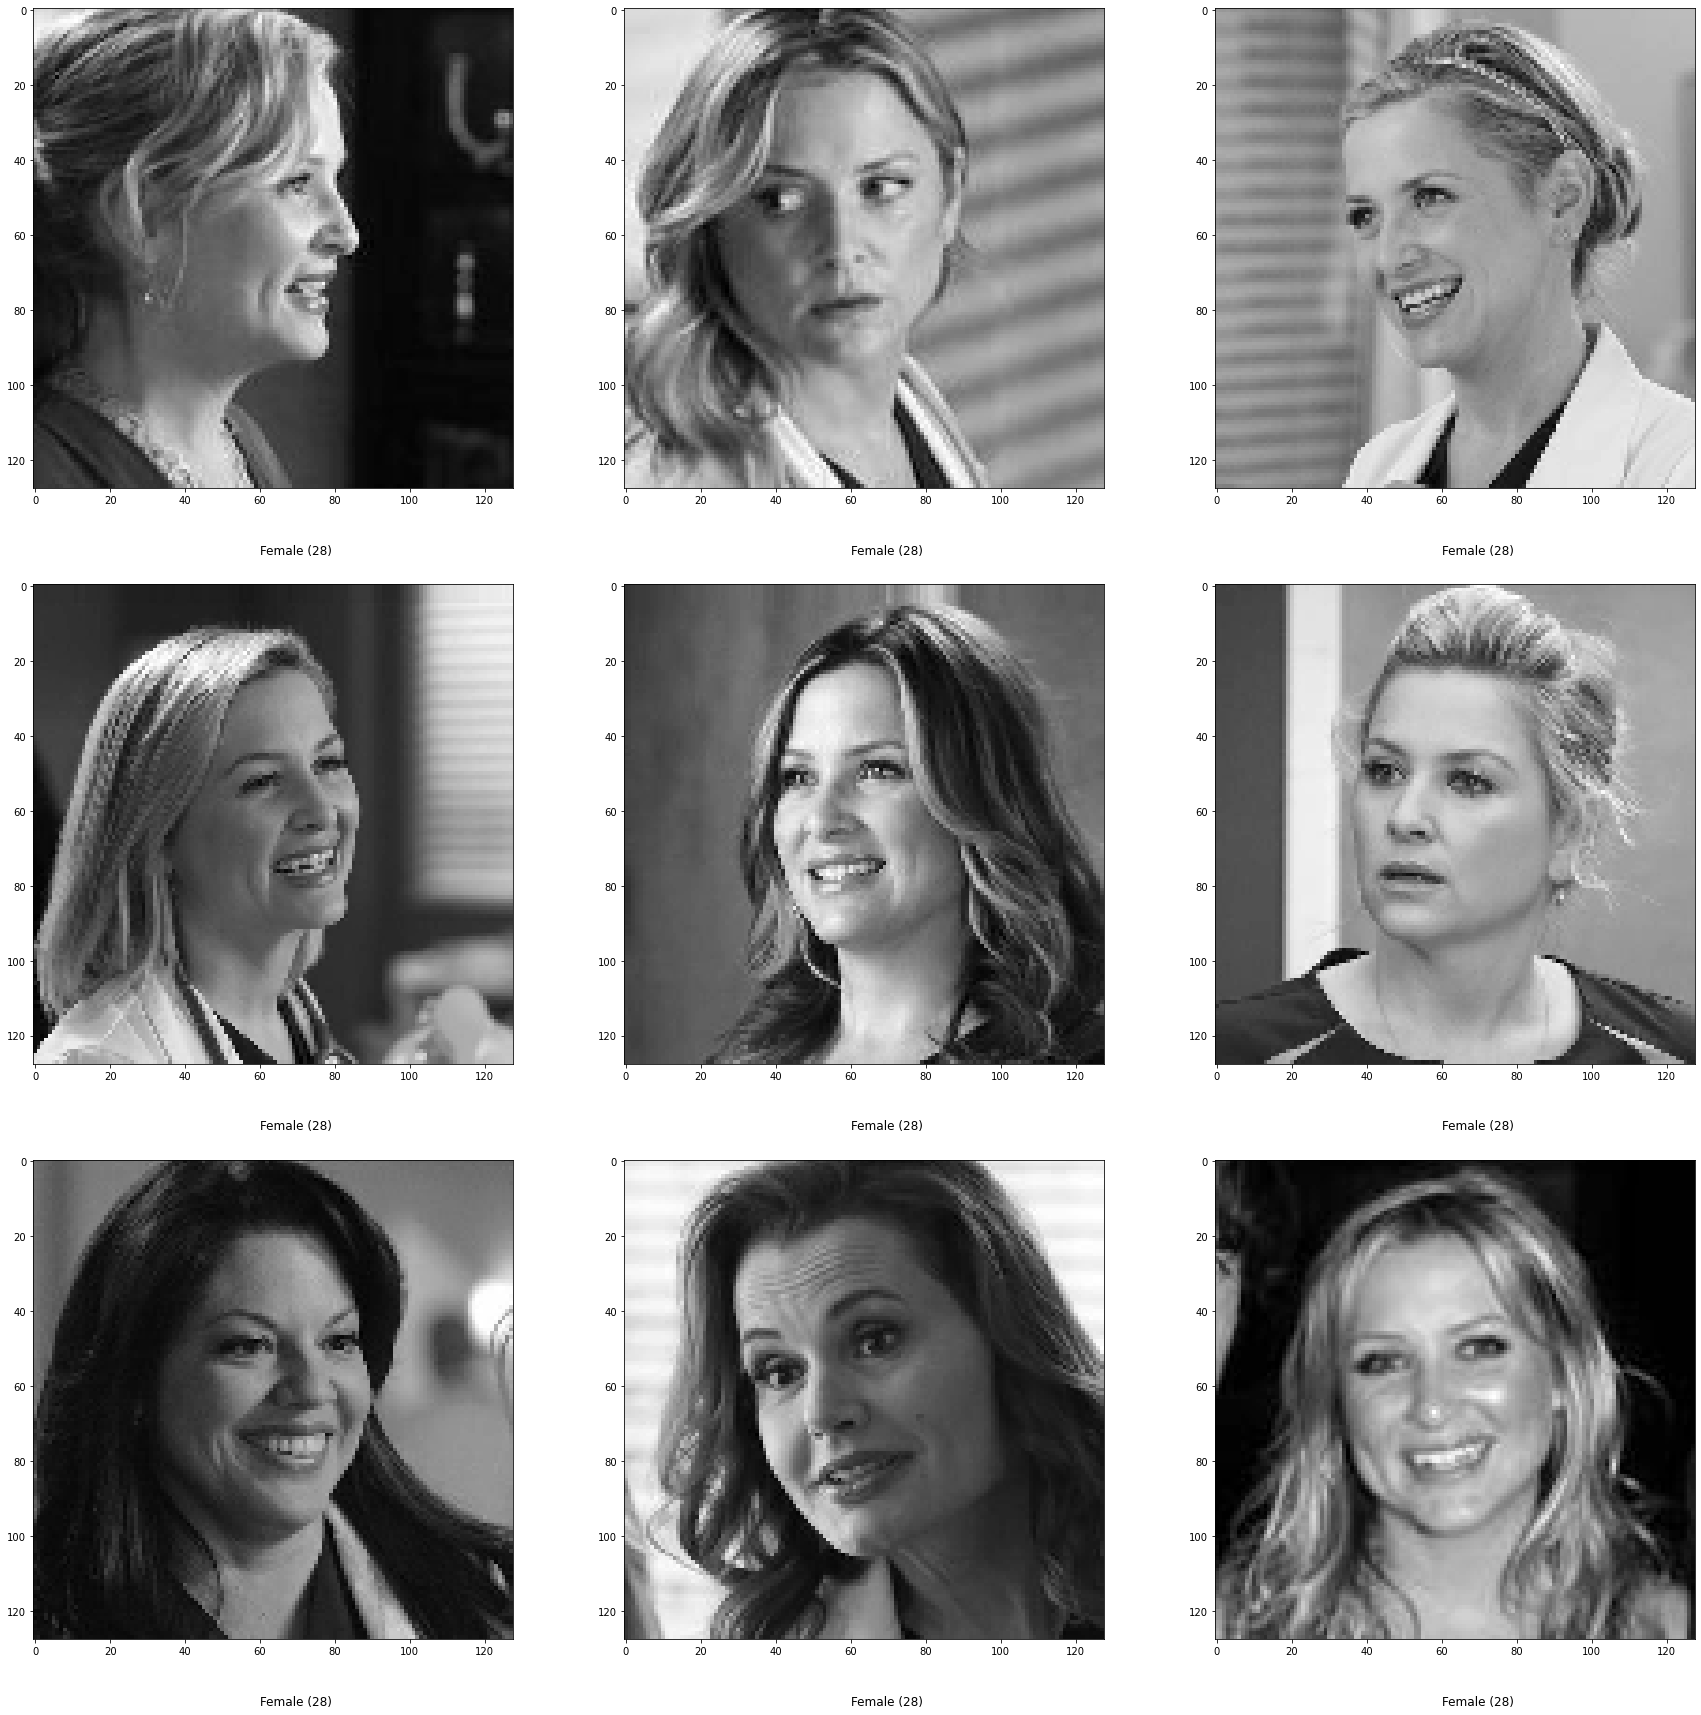

In [65]:
fig, ax = plt.subplots(figsize=(30,30), nrows=3, ncols=3)

idx = 821
gender_dict = {0: "Female", 1: "Male"}

for i in range(3):
    for j in range(3):
        ax[i, j].imshow(input_tensor[idx], cmap="gray")
        ax[i, j].text(x=60, y=145, s=f"{gender_dict[gender_labels[idx]]} ({age_labels[idx]})", fontsize=12)
        idx += 1
plt.show()

In [66]:
y = np.float32(gender_labels.reshape((len(gender_labels), 1)))

In [67]:
y

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [21]:
from sklearn.model_selection import train_test_split

In [89]:
X = np.expand_dims(input_tensor, axis=3)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(input_tensor, y, test_size=0.3)

In [69]:
X_train2 = np.expand_dims(X_train, axis=3)

In [70]:
X_test2 = np.expand_dims(X_test, axis=3)

In [71]:
X_test2.shape

(28593, 128, 128, 1)

In [72]:
X_train2.shape

(66717, 128, 128, 1)

In [73]:
y_train.shape

(66717, 1)

In [80]:
model = models.Sequential()
model.add(layers.Conv2D(16, (4, 4), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='elu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [81]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 125, 125, 16)      272       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 59, 59, 32)        8224      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 27, 27, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 11, 11, 128)      

In [95]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history_gend = model.fit(X, y, validation_split=0.2, epochs=5, batch_size=128)

Epoch 1/5
596/596 [==============================] - 273s 458ms/step - loss: 0.5162 - accuracy: 0.7591 - val_loss: 0.5547 - val_accuracy: 0.7279
Epoch 2/5
596/596 [==============================] - 258s 433ms/step - loss: 0.5057 - accuracy: 0.7652 - val_loss: 0.5488 - val_accuracy: 0.7385
Epoch 3/5
596/596 [==============================] - 249s 417ms/step - loss: 0.4940 - accuracy: 0.7704 - val_loss: 0.5563 - val_accuracy: 0.7383
Epoch 4/5
596/596 [==============================] - 249s 417ms/step - loss: 0.4823 - accuracy: 0.7759 - val_loss: 0.5585 - val_accuracy: 0.7307
Epoch 5/5
596/596 [==============================] - 254s 427ms/step - loss: 0.4671 - accuracy: 0.7823 - val_loss: 0.5901 - val_accuracy: 0.7146


In [97]:
model.save("gender_classifier")

INFO:tensorflow:Assets written to: gender_classifier\assets


In [84]:
model2 = models.Sequential()
model2.add(layers.Conv2D(16, (4, 4), activation='relu', input_shape=(128, 128, 1)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='elu'))
model2.add(layers.Dense(1, activation='linear'))

In [91]:
model2.compile(optimizer='adam',
              loss='mse',
              metrics=['mae', 'mse'])

In [92]:
y2 = np.float32(age_labels.reshape((len(age_labels), 1)))

In [94]:
history = model2.fit(X, y2, epochs=1, validation_split=0.2, batch_size=256)

298/298 [==============================] - 252s 845ms/step - loss: 162.0707 - mae: 10.0312 - mse: 162.0707 - val_loss: 170.2200 - val_mae: 10.2862 - val_mse: 170.2200


In [96]:
model2.save("age_predictor")

INFO:tensorflow:Assets written to: age_predictor\assets


In [100]:
y_pred = np.round(model.predict(X_test2), 0)

In [101]:
from sklearn.metrics import classification_report

In [104]:
print(classification_report(y_test, y_pred, target_names=["Female", "Male"]))

              precision    recall  f1-score   support

      Female       0.80      0.60      0.68     11745
        Male       0.76      0.89      0.82     16848

    accuracy                           0.77     28593
   macro avg       0.78      0.74      0.75     28593
weighted avg       0.77      0.77      0.76     28593



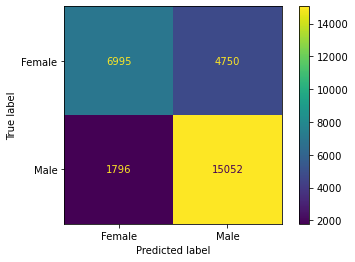

In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Female", "Male"])
disp.plot()
plt.show()